# Practice 1-CNNs (Exercise 1)

##### Ovidio Manteiga Moar
##### Carlos Villar Martínez

In this first practise we are going to develop a deel learning model using the keras library, we have been given a dataset with 100000 pictures of faces and their corresponding labels. The main goal is creating a model that is capable of determining the gender of person in each photo and the age. In this first part we are going to focus on the gender prediction.

In [1]:
# Dataset path
from os import listdir
import os.path

PATH = "C:/Users/corre/OneDrive/Escritorio/Segundo cuatri/DL/Practica 1/datasets/faces/faces_dataset_train/"
PATH_TEST = "C:/Users/corre/OneDrive/Escritorio/Segundo cuatri/DL/Practica 1/datasets/faces/faces_dataset_test/"

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

In [2]:
#Import the necessary libraries
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import pyplot
import json
import os    

### Metadata access

In [3]:

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

In the following code cells images are decoded and divided into trainning set and test set. Something important to take into account is that the images' shape is 32x32 and they have three channels.

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Image shape:  (32, 32, 3)
Label:  0


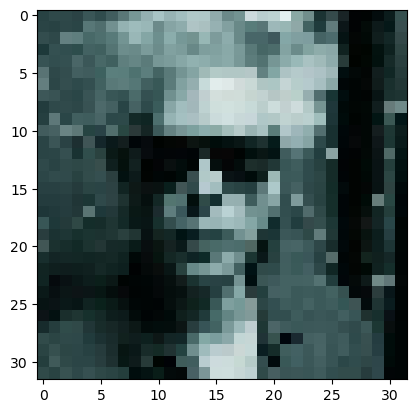

Image shape:  (32, 32, 3)
Label:  1


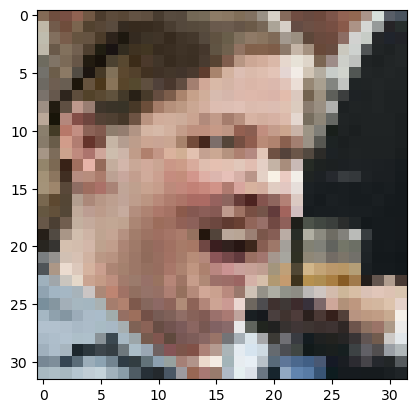

Image shape:  (32, 32, 3)
Label:  1


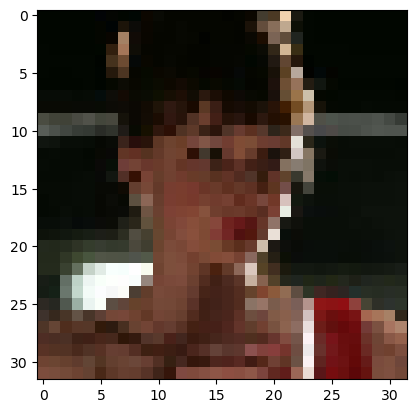

Image shape:  (32, 32, 3)
Label:  0


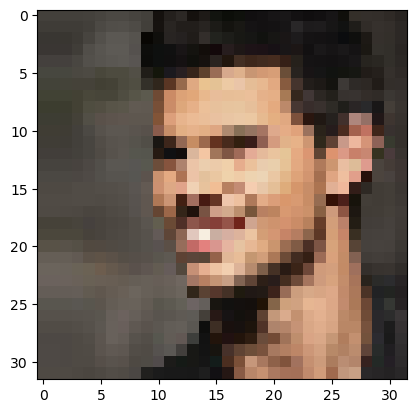

Image shape:  (32, 32, 3)
Label:  1


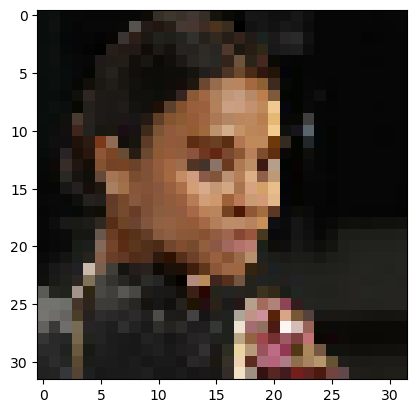

In [5]:


# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

# def process_path_age(file_path):
#     '''Transforma cadenas de la forma 'ruta|edad|genero' a tuplas (imagen, etiqueta)
#     '''
#     parts = tf.strings.split(file_path, '|')
#     age = parts[1]
#     age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
#     gender = parts[2]
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(parts[0])
#     img = decode_img(img)
#     return img, age

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [6]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

C:/Users/corre/OneDrive/Escritorio/Segundo cuatri/DL/Practica 1/datasets/faces/faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [7]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [8]:
# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


### Batch size

In the next cell we define the batch size. It basically defines the number of samples that will be propagated through the network. Let's say we have a dataset with 1000 samples, if we define a batch size of 100 the algorithm will take the first 100 samples of the trainning set and train the network, after doing this it will take next 100 samples and train the network again and it will keep doing this until it has used all samples.

Advantages of using a batch size < number of all samples:

-It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

-Typically networks train faster with mini-batches. That's because we update the weights after each propagation.  

Disadvantages of using a batch size < number of all samples:

-The smaller the batch the less accurate the estimate of the gradient will be.

One thing that can be done here is to star with a small batch size and then trying a bigger batch size each time trying to find one that gives better results and takes a reasonable amount of time. At first we tried with a batch size of 128 but the validation accuracy was fluctuating a bit so we decided to use a batch size of 512 and we obtained the result we were looking for with a more stable validation accuracy.

In [9]:
batch_size = 512
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

### Creating the model
Next thing to do is creating the model. First, we define the input of our model and it´s shape, as it was mentioned before our images are 32x32 and they have 3 chanels so we specify it on the inputs part. After creating the inputs we define the feature learning part, which basically is a bunch of layers that are usually convolutional layers and maxpooling layers. There are more posibilities, for example we use a reescaling layer (as we know intensity of pixels goes from 0 to 255), and regularization layer can be used. These regularization layers are used to avoid overffiting, which basically means that with these layer our model won't learn the noise so it will be able to generalize. Depending on the on the problem we are facing we can choose different regularization layers as there are a lot of different approaches. The last thing to do to create the model is addig a flatten layer which basically creates an output of one vector and we add also a dense layer which is basically used to modify the dimensions of the vetor, but it can also rotate it scale it...

##### Our model
First, the Rescaling layer is used to normalize the input data. The subsequent convolutional layers learn a hierarchy of increasingly complex features that capture relevant patterns in the input images. The MaxPooling layers are used to reduce the spatial dimensions of the feature maps and introduce a degree of translation invariance, which makes the model more robust to small variations in the location of objects in the images. The Dropout layers are used to reduce the risk of overfitting by randomly setting a fraction of the inputs to zero during training, which prevents the model from becoming too specialized to the training data.

The final layer of the model is a dense layer with a single output neuron and a sigmoid activation function, which outputs a probability score between 0 and 1 indicating the likelihood of the input image belonging to the positive class.

We also tried to use some batch normalization and the trainning accuracy was better but the validation accuracy was much worse.

In [14]:
#Creating the model
inputs = keras.Input(shape=(32, 32, 3))

#Feature learning part
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)



#Classification part
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                           

### Compile

Here we compile our model and define the different parameters we want to messure and how we want to messure them. Something important is that here we can meassure the metric accuracy because it's a classification problem but if we use this accuracy in aregression problem will always get an accuracy of zero, but this is not because our model fails everything, it's because for regression problems it makes no sense using that metric and keras won't send and error message, it will keep training the network but it will say "accuracy = 0".

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics="accuracy",
              weighted_metrics=[])

### Training
In the next cell we start the trainning process. Something important to take into account is that we use the test set as the validation set, this is because we've been said that the theachers hold another different set that they are going to use to test the model (it takes some time, separado approximately 90 mins with 25 epochs).

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    ds_train_batch,
    epochs=75,
    validation_data=ds_test_batch,
    callbacks=callbacks)

Epoch 1/75
248/248 [==============================] - 56s 220ms/step - loss: 0.6396 - accuracy: 0.5951 - val_loss: 0.5954 - val_accuracy: 0.6550
Epoch 2/75
248/248 [==============================] - 56s 227ms/step - loss: 0.5670 - accuracy: 0.6949 - val_loss: 0.5706 - val_accuracy: 0.6500
Epoch 3/75
248/248 [==============================] - 58s 233ms/step - loss: 0.5287 - accuracy: 0.7285 - val_loss: 0.5208 - val_accuracy: 0.7400
Epoch 4/75
248/248 [==============================] - 57s 227ms/step - loss: 0.4929 - accuracy: 0.7554 - val_loss: 0.5422 - val_accuracy: 0.6750
Epoch 5/75
248/248 [==============================] - 55s 220ms/step - loss: 0.4660 - accuracy: 0.7763 - val_loss: 0.4564 - val_accuracy: 0.7900
Epoch 6/75
248/248 [==============================] - 55s 219ms/step - loss: 0.4454 - accuracy: 0.7912 - val_loss: 0.4401 - val_accuracy: 0.8100
Epoch 7/75
248/248 [==============================] - 55s 221ms/step - loss: 0.4265 - accuracy: 0.8031 - val_loss: 0.4179 - val_ac

In [19]:
#Here we simply save the model in order to use it in the next exercise of the practise
model.save('genre_model.h5')

In [10]:
test_model = keras.models.load_model('genre_model.h5')
test_loss, test_acc = test_model.evaluate(ds_test_batch)
print(f"Test accuracy: {test_acc:.3f}")

2/2 [==============================] - 1s 68ms/step - loss: 0.3295 - accuracy: 0.8660
Test accuracy: 0.866


### Graphics
By using the matplotlib library we can plot the evolution of the trainning process and see how the trainning accuracy, validation accuracy, trainning loss and validation loss evolve. It's something quite interesting because even though  we already have the values printed in the trainning process here we can see better the evolution and by reading the validation graphs we can see if we are overfitting or underfitting.

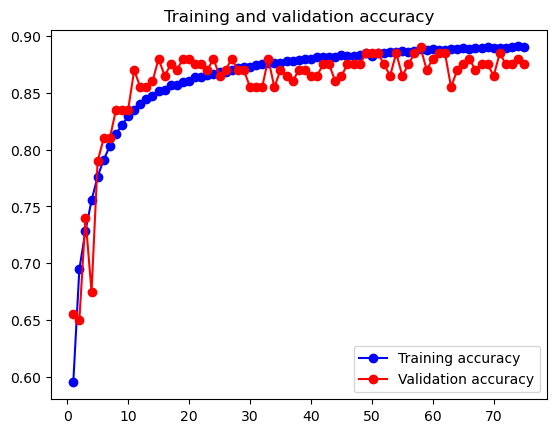

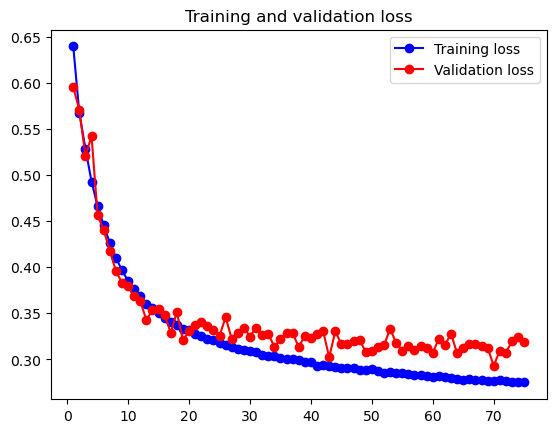

In [18]:

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Results and conclusions

For this first part of the practice the results obtained are pretty satisfactory, the trainning accuracy is around 0.88 and the same happens for the validation accuracy. Taking into account that we realised just a few days before the delivery date that there was an error in the code, the results are still pretty good. There are some thing that can be done to improve the model, for example changing the scale of the images, but changes like that make the trainning phase to take a lot of time.